In [1]:
import xarray as xr 
import pandas as pd
import numpy as np  


In [2]:
from dask.distributed import Client

client = Client()

import s3fs, dask
fs = s3fs.S3FileSystem(anon=False, use_listings_cache=False, asynchronous=True)
dask.config.set(
    {"s3.multipart_chunksize": "50MB"})

In [4]:
fn = '../data/sample_assets.csv'
loss_function = 'HOTHAPS'


## read csv  
df_in = pd.read_csv(fn)[['asset_id','latitude','longitude','asset_type','country_left']]
df_in = df_in.drop_duplicates('asset_id').rename(columns={'latitude':'lat','longitude':'lon','country_left':'country'})
## load asset map 
asset_map = pd.read_csv('../src/asset_map.csv')

## load aircon
aircon = xr.open_zarr('s3://hazard-science-data/productivity_loss_v2/aircon/AirCon_SSPs.zarr/') 
aircon = aircon.sel(SSP='2.0').isel(year=0)['ac_penetration'].chunk(dict(lon=-1)).interpolate_na(method='nearest',dim='lon',limit=3)


## load losses
ds_dict = {}
ds_2020 = {}
for intensity in ['low','moderate','high']:
    ds_2020[intensity] = xr.open_zarr(f's3://hazard-science-data/productivity_loss_v2/climate_outputs/observations/ERA5_{loss_function}_productivity_loss_{intensity}.zarr.zarr/')
for scenario in ['ssp126','ssp245','ssp370','ssp585']:
    ds_dict[scenario] = {}
    for intensity in ['low','moderate','high']:
        ds_dict[scenario][intensity] = xr.open_zarr(f"s3://hazard-science-data/productivity_loss_v2/climate_outputs/projections_corrected/{scenario}/CMIP6-ScenarioMIP_{loss_function}_productivity_loss_{intensity}_{scenario}.zarr.zarr/")

In [ ]:

scenarios = ['ssp126', 'ssp585']

# List to accumulate all rows (one per asset_id, year, scenario)
rows_list = []

for scenario in scenarios:
    # Create a temporary copy of your asset data and map work_intensity
    df_temp = df_in.loc[:40, :].copy(deep=True)
    df_temp['work_intensity'] = df_temp['asset_type'].map(asset_map.set_index('asset_type')['intensity'])
    
    # Get the years available for this scenario.
    # Here, we assume the years are the same for every asset in a scenario.
    years = np.concat([[2020],ds_dict[scenario]['high'].year.values])
    stats = ['median', 'minimum', 'maximum']
    
    # Process each asset row
    for _, row in df_temp.iterrows():
        # Get the dataset corresponding to the asset's work intensity in the current scenario
        ds = ds_dict[scenario][row['work_intensity']]
        ds_2020_local = ds_2020[row['work_intensity']].sel(lat=row['lat'], lon=row['lon'], method='nearest')

        # For each year, extract the values for all stats and build a new row
        for year in years:
            row_dict = row.to_dict()  # Copy the asset info (like asset_id, lat, lon, etc.)
            row_dict['scenario'] = scenario
            
            if year == 2020:
                row_dict['year'] = 2020
                for stat in stats:
                    value = np.round(ds_2020_local['median'].values,2)
                    row_dict[stat] = value

            else:
                row_dict['year'] = year
                # Get each statistic value from the dataset (using nearest neighbor)
                for stat in stats:
                    value = np.round(ds.sel(lat=row['lat'], lon=row['lon'], year=year, method='nearest')[stat].values, 2)
                    row_dict[stat] = value
                # Append the new row to our list
            rows_list.append(row_dict)

# Create the final long DataFrame
df_long = pd.DataFrame(rows_list)
df_long.to_csv(f"../output_csvs/unscaledcsv")

In [33]:
# Make a deep copy of df_long so that the original remains unchanged
df_long_scaled = df_long.copy(deep=True)

# Create a new column for AC_penetration and initialize with NaN
df_long_scaled['AC_penetration'] = np.nan

# Iterate over each row to compute AC penetration and adjust the values
for i in df_long_scaled.index:
    lat = df_long_scaled.loc[i, 'lat']
    lon = df_long_scaled.loc[i, 'lon']
    # Compute AC_penetration using the nearest neighbor from the aircon dataset
    ac_val = np.round(aircon.sel(lat=lat, lon=lon, method='nearest').values, 2)
    df_long_scaled.loc[i, 'AC_penetration'] = ac_val

    # If a valid AC penetration value is found, scale the statistics accordingly
    if not pd.isna(ac_val):
        # Scale 'median', 'minimum', and 'maximum' by multiplying with (1 - AC_penetration)
        df_long_scaled.loc[i, ['median', 'minimum', 'maximum']] *= (1 - ac_val)


2025-03-19 14:50:53,764 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-7e9a4c5018c44c0dd32fea1ffd536fcb',): 'forgotten'}
2025-03-19 14:50:54,146 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8fdd0cdd8ea193877d3f53c61dfc68e4',): 'waiting'}
2025-03-19 14:50:54,269 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-8fdd0cdd8ea193877d3f53c61dfc68e4',): 'forgotten'}
2025-03-19 14:50:54,815 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-894c29ad8309c45e21773f8ab4b06ab3',): 'waiting'}
2025-03-19 14:50:54,940 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-894c29ad8309c45e21773f8ab4b06ab3',): 'forgotten'}
2025-03-19 14:50:55,486 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-1b68b53ebcf6df48d3190d1e9cf3a532',): 'forgotten'}
2025-03-19 14:50:55,897 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-c0a734b7d0a2cc45e4a6d153e8cb0976',): 'forgotten'}
2025-03-19 14:50:

2025-03-19 14:50:53,766 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-7e9a4c5018c44c0dd32fea1ffd536fcb',),)
2025-03-19 14:50:54,148 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8fdd0cdd8ea193877d3f53c61dfc68e4',),)
2025-03-19 14:50:54,269 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-8fdd0cdd8ea193877d3f53c61dfc68e4',),)
2025-03-19 14:50:54,816 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-894c29ad8309c45e21773f8ab4b06ab3',),)
2025-03-19 14:50:54,942 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-894c29ad8309c45e21773f8ab4b06ab3',),)
2025-03-19 14:50:55,487 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-1b68b53ebcf6df48d3190d1e9cf3a532',),)
2025-03-19 14:50:55,898 - distributed.client - WARNING - Couldn't gather 1 keys, rescheduling (('getitem-c0a734b7d0a2cc45e4a6d153e8cb0976',),)

In [60]:
df_long_scaled

,asset_id,lat,lon,asset_type,country,work_intensity,scenario,year,median,minimum,maximum,AC_penetration
0,1203 - BP INTERNATIONAL LIMITED,51.73473,5.494284,HIGH_ST,Netherlands,low,ssp126,2020,0.0000,0.0000,0.0000,0.26
1,1203 - BP INTERNATIONAL LIMITED,51.73473,5.494284,HIGH_ST,Netherlands,low,ssp126,2025,0.0148,0.0148,0.0148,0.26
2,1203 - BP INTERNATIONAL LIMITED,51.73473,5.494284,HIGH_ST,Netherlands,low,ssp126,2030,0.0148,0.0148,0.0148,0.26
3,1203 - BP INTERNATIONAL LIMITED,51.73473,5.494284,HIGH_ST,Netherlands,low,ssp126,2035,0.0148,0.0148,0.0148,0.26
4,1203 - BP INTERNATIONAL LIMITED,51.73473,5.494284,HIGH_ST,Netherlands,low,ssp126,2040,0.0148,0.0148,0.0148,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...
955,104 - RELIANCE INDUSTRIES LIMITED,32.13500,47.520000,OIL_GAS_POWER_PLANT,Iraq,high,ssp585,2060,5.4264,4.5416,8.3888,0.44
956,104 - RELIANCE INDUSTRIES LIMITED,32.13500,47.520000,OIL_GAS_POWER_PLANT,Iraq,high,ssp585,2070,7.1232,5.8856,11.1888,0.44
957,104 - RELIANCE INDUSTRIES LIMITED,32.13500,47.520000,OIL_GAS_POWER_PLANT,Iraq,high,ssp585,2080,8.4560,7.3696,12.4712,0.44
958,104 - RELIANCE INDUSTRIES LIMITED,32.13500,47.520000,OIL_GAS_POWER_PLANT,Iraq,high,ssp585,2090,10.4496,8.6128,14.9128,0.44


In [34]:
import seaborn as sns 
import random
import matplotlib.pyplot as plt  

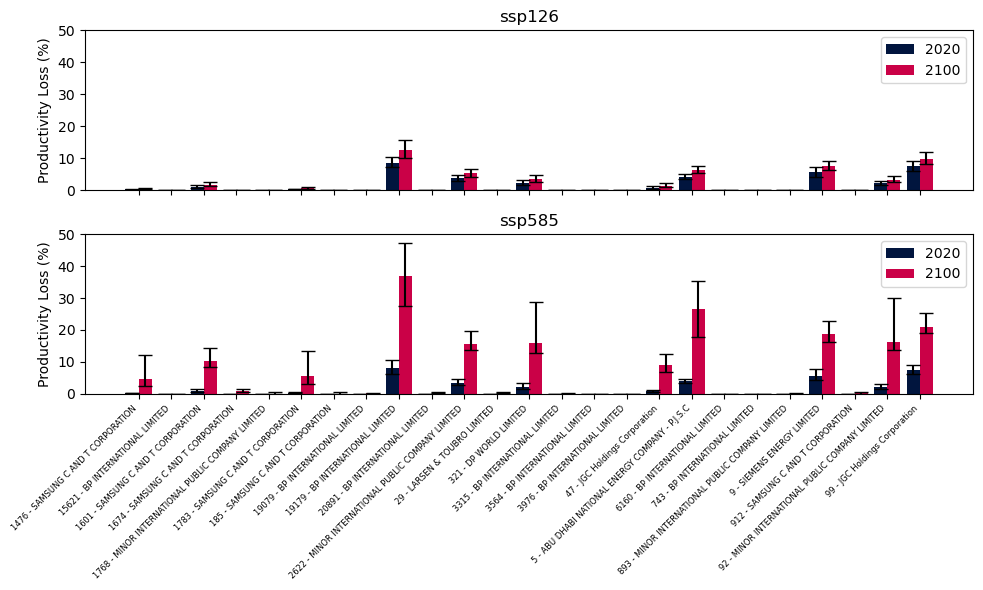

In [64]:

# Define scenarios, e.g., ['ssp126', 'ssp585']
scenarios = ['ssp126','ssp585']

# Select 25 random asset_ids from the entire long-format DataFrame
sample_ids = random.sample(list(df_long_scaled['asset_id'].unique()), 25)

# Create a subplot with one row per scenario
f, ax = plt.subplots(len(scenarios), 1, figsize=(10, 3 * len(scenarios)), sharex=True)

for i, scenario in enumerate(scenarios):
    # Filter for the current scenario, the sampled asset_ids, and only the years 2025 and 2100.
    data = df_long_scaled[
        (df_long_scaled['scenario'] == scenario) &
        (df_long_scaled['asset_id'].isin(sample_ids)) &
        (df_long_scaled['year'].isin([2025, 2100]))
    ].copy()
    
    # Pivot so each asset_id is one row, and columns become "2025_median", "2025_minimum", etc.
    data_pivot = data.pivot(index='asset_id', columns='year', values=['median', 'minimum', 'maximum'])
    # Flatten the MultiIndex columns to single strings.
    data_pivot.columns = [f"{year}_{stat}" for stat, year in data_pivot.columns]
    data_pivot = data_pivot.reset_index()

    # Define x-axis positions for each asset.
    x = np.arange(len(data_pivot))

    # Define error bars for 2025 and 2100.
    err_2025 = [np.abs(data_pivot["2025_median"] - data_pivot["2025_minimum"]),
                np.abs(data_pivot["2025_maximum"] - data_pivot["2025_median"])]
    err_2100 = [np.abs(data_pivot["2100_median"] - data_pivot["2100_minimum"]),
                np.abs(data_pivot["2100_maximum"] - data_pivot["2100_median"])]

    bar_width = 0.4
    # Select the appropriate axis handle.
    a = ax[i] if len(scenarios) > 1 else ax

    # Plot bars with error bars for both years.
    a.bar(x - bar_width / 2, data_pivot["2025_median"], yerr=err_2025, width=bar_width,
          capsize=5, label="2020", color="xkcd:navy")
    a.bar(x + bar_width / 2, data_pivot["2100_median"], yerr=err_2100, width=bar_width,
          capsize=5, label="2100", color="xkcd:ruby")

    a.set_xticks(x)
    a.set_xticklabels(data_pivot['asset_id'], rotation=45,fontsize=6,ha = 'right')
    a.set_ylim(0, 50)
    # a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(scenario)

plt.tight_layout()
plt.show()

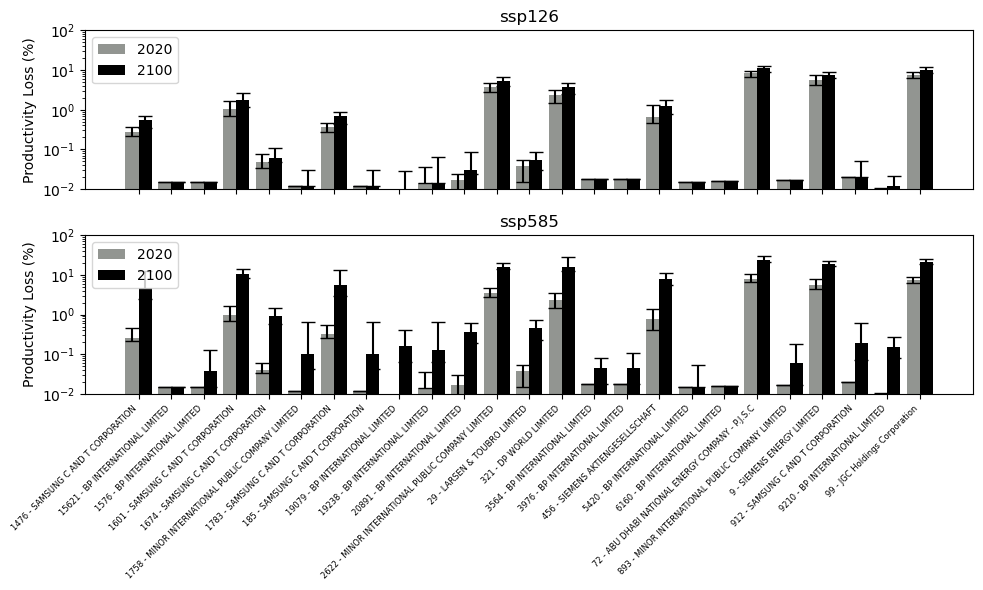

In [72]:

# Define scenarios, e.g., ['ssp126', 'ssp585']
scenarios = ['ssp126','ssp585']

# Select 25 random asset_ids from the entire long-format DataFrame
sample_ids = random.sample(list(df_long_scaled['asset_id'].unique()), 25)

# Create a subplot with one row per scenario
f, ax = plt.subplots(len(scenarios), 1, figsize=(10, 3 * len(scenarios)), sharex=True)

for i, scenario in enumerate(scenarios):
    # Filter for the current scenario, the sampled asset_ids, and only the years 2025 and 2100.
    data = df_long_scaled[
        (df_long_scaled['scenario'] == scenario) &
        (df_long_scaled['asset_id'].isin(sample_ids)) &
        (df_long_scaled['year'].isin([2025, 2100]))
    ].copy()
    
    # Pivot so each asset_id is one row, and columns become "2025_median", "2025_minimum", etc.
    data_pivot = data.pivot(index='asset_id', columns='year', values=['median', 'minimum', 'maximum'])
    # Flatten the MultiIndex columns to single strings.
    data_pivot.columns = [f"{year}_{stat}" for stat, year in data_pivot.columns]
    data_pivot = data_pivot.reset_index()

    # Define x-axis positions for each asset.
    x = np.arange(len(data_pivot))

    # Define error bars for 2025 and 2100.
    err_2025 = [np.abs(data_pivot["2025_median"] - data_pivot["2025_minimum"]),
                np.abs(data_pivot["2025_maximum"] - data_pivot["2025_median"])]
    err_2100 = [np.abs(data_pivot["2100_median"] - data_pivot["2100_minimum"]),
                np.abs(data_pivot["2100_maximum"] - data_pivot["2100_median"])]

    bar_width = 0.4
    # Select the appropriate axis handle.
    a = ax[i] if len(scenarios) > 1 else ax

    # Plot bars with error bars for both years.
    a.bar(x - bar_width / 2, data_pivot["2025_median"], yerr=err_2025, width=bar_width,
          capsize=5, label="2020", color="xkcd:grey")
    a.bar(x + bar_width / 2, data_pivot["2100_median"], yerr=err_2100, width=bar_width,
          capsize=5, label="2100", color="xkcd:black")

    a.set_xticks(x)
    a.set_xticklabels(data_pivot['asset_id'], rotation=45,fontsize=6,ha = 'right')
    a.set_ylim(0.01, 100)
    a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(scenario)

plt.tight_layout()
plt.show()

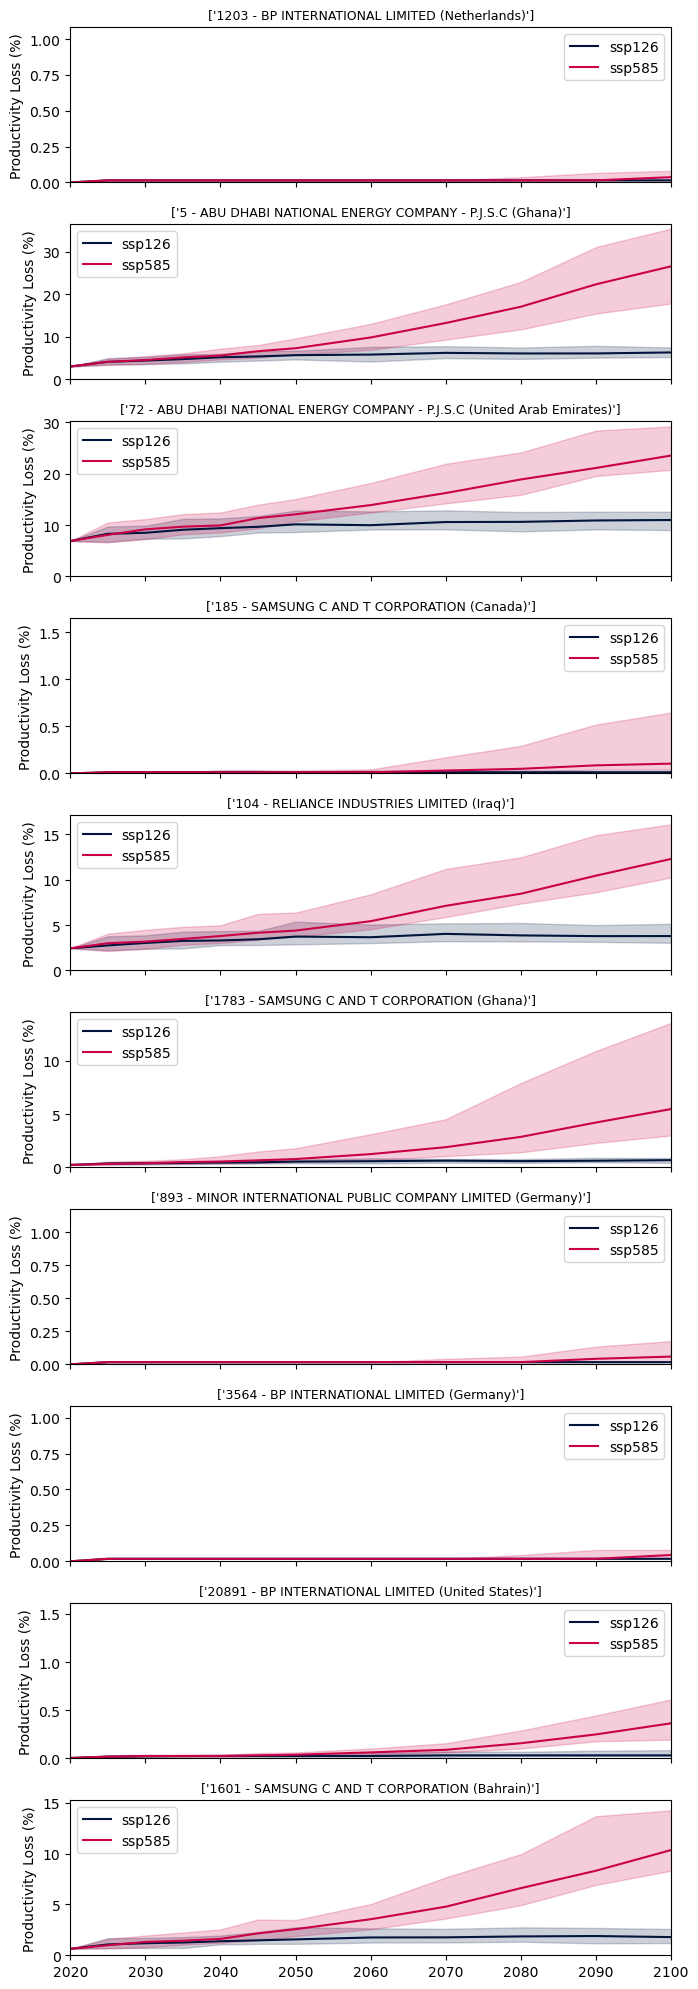

In [74]:
ids = random.sample(list(df_long_scaled['asset_id'].unique()),10)
f,ax = plt.subplots(len(ids),1,figsize=(7,2*len(ids)),sharex=True)

colors = {
    'ssp126':'xkcd:navy',
    'ssp245':'xkcd:teal',
    'ssp370':'xkcd:orange',
    'ssp585':'xkcd:ruby'
}

for j,id in enumerate(ids):
    if len(scenarios)>1:
        a = ax[j]
    else:
        a = ax
    

    for i, scenario in enumerate(scenarios):
        y = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['median']
        yhigh = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['maximum']
        ylow = df_long_scaled[(df_long_scaled['asset_id']==id)&(df_long_scaled['scenario']==scenario)]['minimum']
        x = [2020,2025,2030,2035,2040,2045,2050,2060,2070,2080,2090,2100]

        a.fill_between(x,ylow,yhigh,alpha=0.2,color=colors[scenario])
        a.plot(x,y,color=colors[scenario],label=scenario)
    a.set_ylim(0,np.max(yhigh)+1)
    plt.xlim(2020,2100)
    # a.set_yscale('log')
    a.set_ylabel('Productivity Loss (%)')
    a.legend()
    a.set_title(id + ' (' + df_long_scaled[(df_long_scaled['asset_id']==id)]['country'].unique() + ')',fontsize=9)
plt.tight_layout()


In [87]:
id

'19238 - BP INTERNATIONAL LIMITED'

In [26]:
y

2025